In [83]:
# Config Data Structure
import pandas as pd
from datetime import datetime as dt
from pymongo import MongoClient as mc
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import pprint as pp
import random as ran
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM
from tensorflow.keras.utils import to_categorical
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

household_col = keti_db.household_info
weather_col = keti_db.weather_info

In [84]:
# TimeSlot In
hh_db_datas = household_col.find_one({"uid": "아파트1-104-1206"})
hh_db_datas

uid_in, timeslot = hh_db_datas['uid'], hh_db_datas['timeslot']

datelist = [
    dt.strptime(ts['time'], "%Y-%m-%d T%H:%M %z").date()
    for ts in timeslot
]
datelist = list(set(datelist))
datelist.sort()

ts_datas = {}
start_idx = 0
end_idx = 96
enl = 1

for date in datelist:
    ts_datas[date] = [ts['power'] *
                      enl for ts in timeslot[start_idx:end_idx]]
    start_idx = end_idx
    end_idx = end_idx + 96

ts_datas = pd.DataFrame(ts_datas).T
hh_datas = ts_datas.reset_index().copy()

hh_datas.rename(columns={"index": "date"}, inplace=True)
hh_datas['date'] = pd.to_datetime(hh_datas['date'])

hh_datas.set_index('date', inplace=True)

# Merging
merge_size = 4
merge_datas = pd.DataFrame()
for date in hh_datas.index:
    merge_ts = []
    new_ts_size = round(len(hh_datas.loc[date]) / merge_size)
    
    for idx in range(0,new_ts_size):
        merge_ts.append(
            round(hh_datas.loc[date][merge_size * idx:merge_size * (idx + 1)].sum(), 3) * 1000
        )
    merge_datas[date] = merge_ts
    
def get_season_no(month):
    if month in [3,4,5]:
        return 1 # 봄
    elif month in [6,7,8]:
        return 2 # 여름
    elif month in [9,10,11]:
        return 3 # 가을
    elif month in [12,1,2]:
        return 4 # 겨울
    
separate_datas_col = list(filter(lambda data: get_season_no(data.month) == 1, merge_datas.columns))
# print(separate_datas_col)
merge_datas = merge_datas[separate_datas_col]
merge_datas

,2018-05-01,2018-05-02,2018-05-03,2018-05-04,2018-05-05,2018-05-06,2018-05-07,2018-05-08,2018-05-09,2018-05-10,...,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30
0,341.0,275.0,183.0,309.0,305.0,397.0,347.0,345.0,312.0,321.0,...,182.0,60.0,63.0,66.0,149.0,164.0,130.0,290.0,56.0,45.0
1,337.0,201.0,235.0,308.0,179.0,409.0,178.0,272.0,191.0,208.0,...,209.0,38.0,49.0,62.0,52.0,63.0,46.0,267.0,53.0,44.0
2,324.0,176.0,167.0,309.0,180.0,400.0,173.0,206.0,183.0,203.0,...,197.0,50.0,41.0,46.0,67.0,65.0,42.0,244.0,62.0,59.0
3,319.0,210.0,165.0,309.0,172.0,384.0,176.0,204.0,173.0,189.0,...,194.0,60.0,64.0,51.0,54.0,39.0,60.0,276.0,63.0,58.0
4,235.0,199.0,163.0,311.0,171.0,276.0,178.0,173.0,170.0,184.0,...,46.0,54.0,61.0,64.0,41.0,56.0,33.0,232.0,61.0,33.0
5,169.0,202.0,164.0,217.0,174.0,206.0,182.0,180.0,170.0,172.0,...,66.0,35.0,35.0,64.0,66.0,63.0,54.0,135.0,87.0,54.0
6,200.0,199.0,162.0,218.0,169.0,200.0,180.0,188.0,207.0,169.0,...,68.0,62.0,57.0,47.0,63.0,71.0,59.0,93.0,50.0,59.0
7,171.0,252.0,173.0,212.0,164.0,199.0,232.0,179.0,215.0,216.0,...,49.0,60.0,63.0,49.0,39.0,46.0,28.0,93.0,46.0,49.0
8,170.0,213.0,226.0,242.0,162.0,199.0,221.0,212.0,244.0,169.0,...,50.0,40.0,46.0,64.0,59.0,62.0,59.0,66.0,51.0,40.0
9,172.0,173.0,178.0,187.0,166.0,200.0,217.0,171.0,204.0,170.0,...,141.0,50.0,46.0,63.0,65.0,49.0,47.0,89.0,60.0,58.0


In [85]:
# Set Test Datas
# 계절별 10% 랜덤하게
def get_season_no(month):
    if month in [3,4,5]:
        return 1 # 봄
    elif month in [6,7,8]:
        return 2 # 여름
    elif month in [9,10,11]:
        return 3 # 가을
    elif month in [12,1,2]:
        return 4 # 겨울
    
test_merge_datas = pd.DataFrame();

for i in range(1,2):
    filter_list = list(filter(lambda date: get_season_no(date.month) == i, merge_datas.columns))
    test_list_idx = list()
    while True:
        filter_data = filter_list[ran.randrange(0,len(filter_list))]
        if filter_data not in test_list_idx:
            test_list_idx.append(filter_data)
            
        if len(test_list_idx) >= (len(filter_list) * 15 / 100):
            break;
    test_merge_datas = pd.concat([test_merge_datas, merge_datas[test_list_idx]], axis=1)
    merge_datas.drop(test_list_idx, axis=1, inplace=True)

test_merge_datas

,2019-04-21,2019-03-17,2018-05-29,2019-03-16,2018-05-28,2019-03-03,2019-03-29,2018-05-22,2019-03-13,2019-03-23,2018-05-03,2019-04-25,2018-05-30,2019-04-23
0,182.0,207.0,231.0,46.0,216.0,112.0,80.0,313.0,165.0,35.0,183.0,149.0,205.0,63.0
1,209.0,214.0,180.0,41.0,254.0,128.0,78.0,311.0,110.0,64.0,235.0,52.0,204.0,49.0
2,197.0,109.0,208.0,58.0,218.0,251.0,93.0,254.0,74.0,63.0,167.0,67.0,229.0,41.0
3,194.0,39.0,214.0,46.0,203.0,208.0,85.0,223.0,120.0,40.0,165.0,54.0,224.0,64.0
4,46.0,59.0,206.0,41.0,199.0,113.0,73.0,212.0,118.0,49.0,163.0,41.0,213.0,61.0
5,66.0,49.0,202.0,58.0,187.0,92.0,94.0,202.0,99.0,61.0,164.0,66.0,208.0,35.0
6,68.0,37.0,200.0,43.0,186.0,102.0,99.0,199.0,140.0,51.0,162.0,63.0,210.0,57.0
7,49.0,57.0,234.0,43.0,236.0,112.0,68.0,198.0,86.0,39.0,173.0,39.0,247.0,63.0
8,50.0,47.0,200.0,57.0,194.0,108.0,93.0,189.0,37.0,59.0,226.0,59.0,216.0,46.0
9,141.0,38.0,201.0,40.0,176.0,88.0,91.0,190.0,68.0,59.0,178.0,65.0,213.0,46.0


In [86]:
y = reduce(lambda acc, cur: cur + acc ,merge_datas.values.tolist(), [])
value_size = len(y)
print(value_size)

1872


In [87]:
# Config Training Datas
wt_db_datas = weather_col.find()
wt_datas = pd.DataFrame()
for wt in wt_db_datas:
    tmp = pd.DataFrame()
    tmp['date'] = [wt['date']]
    tmp['weather'] = [wt['weather']]
    tmp['avg_ta'] = round(float(wt['avgTa']))
    tmp['avg_rhm'] = round(float(wt['avgRhm']))
    
    wt_datas = pd.concat([wt_datas, tmp])

# weather 정수 인코딩
weather_count = Counter(wt_datas['weather'])
weather_integer = dict()
rank = 1
for key, count in weather_count.most_common():
    weather_integer[key] = rank
    rank += 1
pp.pprint(weather_integer)
wt_datas['weather_no'] = [weather_integer[weather] for weather in wt_datas['weather']]
wt_datas

def get_season_no(month):
    if month in [3,4,5]:
        return 1 # 봄
    elif month in [6,7,8]:
        return 2 # 여름
    elif month in [9,10,11]:
        return 3 # 가을
    elif month in [12,1,2]:
        return 4 # 겨울
    
# Date, Season Utils
wt_datas['season_no'] = [get_season_no(weather.month) for weather in wt_datas['date']] 
wt_datas['day_no'] = [weather.weekday() + 1 for weather in wt_datas['date']] 

sample_weather_col = ['season_no','day_no','weather_no','avg_ta', 'avg_rhm']
sample_weather_col_2 = ['date','season_no','day_no','weather','weather_no','avg_ta', 'avg_rhm']
wt_datas[sample_weather_col_2]

{'눈': 5,
 '박무': 4,
 '비': 3,
 '소나기': 7,
 '안개': 10,
 '안개비': 11,
 '연무': 2,
 '진눈깨비': 12,
 '채운': 8,
 '특이사항 없음': 1,
 '햇무리': 6,
 '황사': 9}


,date,season_no,day_no,weather,weather_no,avg_ta,avg_rhm
0,2018-05-01,1,2,연무,2,20,73
0,2018-05-02,1,3,비,3,15,90
0,2018-05-03,1,4,비,3,11,62
0,2018-05-04,1,5,특이사항 없음,1,14,46
0,2018-05-05,1,6,특이사항 없음,1,18,47
...,...,...,...,...,...,...,...
0,2019-04-26,1,5,비,3,8,82
0,2019-04-27,1,6,햇무리,6,12,53
0,2019-04-28,1,7,비,3,13,49
0,2019-04-29,1,1,햇무리,6,13,53


In [88]:
# Config Sample Datas - Padding
# Data Preprocessing
def get_samples(datas):
    samples = list()
    for col in datas:
        timeslot = datas[col].values.tolist()
        weather = wt_datas[wt_datas['date'] == col][sample_weather_col].values.tolist()[0]
        for time in range(1,25):
            samples.append(weather + timeslot[:time])

    print("Samples Before Padding Process")
    print(np.array(samples))
    print("\nTranining Sample Size : {}".format(len(samples)))
    
    return samples

def get_padding_samples(samples):    
    # Padding
    pad_samples = list()
    SAMPLE_MAX_LEN = max([len(s) for s in samples])
    print("Tranining Sample MAX_LEN : {}".format(SAMPLE_MAX_LEN))
    for sample in samples:
        err = SAMPLE_MAX_LEN - len(sample)
        if err == 0:
            pad_samples.append(sample)
        else:
            pad_data = [0 for i in range(0, err)]
            pad_samples.append(pad_data + sample)
    print("\nFinal Samples")
    print(np.array(pad_samples))
    
    return pad_samples
    
test_samples = get_samples(test_merge_datas)
test_samples = get_padding_samples(test_samples)

training_samples = get_samples(merge_datas)
training_samples = get_padding_samples(training_samples)

Samples Before Padding Process
[list([1, 7, 4, 15, 78, 182.0]) list([1, 7, 4, 15, 78, 182.0, 209.0])
 list([1, 7, 4, 15, 78, 182.0, 209.0, 197.0])
 list([1, 7, 4, 15, 78, 182.0, 209.0, 197.0, 194.0])
 list([1, 7, 4, 15, 78, 182.0, 209.0, 197.0, 194.0, 46.0])
 list([1, 7, 4, 15, 78, 182.0, 209.0, 197.0, 194.0, 46.0, 66.0])
 list([1, 7, 4, 15, 78, 182.0, 209.0, 197.0, 194.0, 46.0, 66.0, 68.0])
 list([1, 7, 4, 15, 78, 182.0, 209.0, 197.0, 194.0, 46.0, 66.0, 68.0, 49.0])
 list([1, 7, 4, 15, 78, 182.0, 209.0, 197.0, 194.0, 46.0, 66.0, 68.0, 49.0, 50.0])
 list([1, 7, 4, 15, 78, 182.0, 209.0, 197.0, 194.0, 46.0, 66.0, 68.0, 49.0, 50.0, 141.0])
 list([1, 7, 4, 15, 78, 182.0, 209.0, 197.0, 194.0, 46.0, 66.0, 68.0, 49.0, 50.0, 141.0, 59.0])
 list([1, 7, 4, 15, 78, 182.0, 209.0, 197.0, 194.0, 46.0, 66.0, 68.0, 49.0, 50.0, 141.0, 59.0, 127.0])
 list([1, 7, 4, 15, 78, 182.0, 209.0, 197.0, 194.0, 46.0, 66.0, 68.0, 49.0, 50.0, 141.0, 59.0, 127.0, 203.0])
 list([1, 7, 4, 15, 78, 182.0, 209.0, 197.0, 1

<ipython-input-88-f7267c0eac4d>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array(samples))


In [89]:
# Set Tranining Data
training_samples = np.array(training_samples)

train_X = training_samples[:,:-1]
train_y = training_samples[:,-1]

# Set Test Data
test_samples = np.array(test_samples)
test_X = test_samples[:,:-1]
test_y = test_samples[:,-1]

print("Input Data For Training")
print(np.array(train_X))
print()
print("Output Data For Training")
print(np.array(train_y))

print("Input Data For Test")
print(np.array(test_X))
print()
print("Output Data For Test")
print(np.array(test_y))

Input Data For Training
[[  0.   0.   0. ...   2.  20.  73.]
 [  0.   0.   0. ...  20.  73. 341.]
 [  0.   0.   0. ...  73. 341. 337.]
 ...
 [  0.   0.   1. ...  38.  61.  59.]
 [  0.   1.   2. ...  61.  59.  30.]
 [  1.   2.   6. ...  59.  30.  56.]]

Output Data For Training
[341. 337. 324. ...  30.  56.  58.]
Input Data For Test
[[  0.   0.   0. ...   4.  15.  78.]
 [  0.   0.   0. ...  15.  78. 182.]
 [  0.   0.   0. ...  78. 182. 209.]
 ...
 [  0.   0.   1. ...  48. 317. 208.]
 [  0.   1.   2. ... 317. 208. 262.]
 [  1.   2.   2. ... 208. 262. 202.]]

Output Data For Test
[182. 209. 197. 194.  46.  66.  68.  49.  50. 141.  59. 127. 203. 140.
 125.  52.  64.  61. 132. 258. 258. 213. 183. 158. 207. 214. 109.  39.
  59.  49.  37.  57.  47.  38.  57.  48. 167.  61.  65. 147. 223. 250.
 256. 207. 195. 180. 210. 200. 231. 180. 208. 214. 206. 202. 200. 234.
 200. 201. 178. 202. 180. 176. 201. 179. 211. 212. 221. 378. 366. 364.
 394. 455.  46.  41.  58.  46.  41.  58.  43.  43.  57.  40. 

In [90]:
one_hot_y = to_categorical(train_y,num_classes=value_size)
one_hot_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [91]:
model_2 = Sequential()
model_2.add(Embedding(value_size, 10, input_length=28))
model_2.add(LSTM(64))
model_2.add(Dense(value_size, activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 28, 10)            18720     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dense_9 (Dense)              (None, 1872)              121680    
Total params: 159,600
Trainable params: 159,600
Non-trainable params: 0
_________________________________________________________________


In [92]:
model_2.fit(train_X, one_hot_y, epochs=1000, verbose=2)

Epoch 1/1000
59/59 - 2s - loss: 6.8289 - accuracy: 0.0246
Epoch 2/1000
59/59 - 0s - loss: 5.5818 - accuracy: 0.0310
Epoch 3/1000
59/59 - 0s - loss: 5.4875 - accuracy: 0.0310
Epoch 4/1000
59/59 - 0s - loss: 5.4623 - accuracy: 0.0310
Epoch 5/1000
59/59 - 0s - loss: 5.4475 - accuracy: 0.0310
Epoch 6/1000
59/59 - 0s - loss: 5.4339 - accuracy: 0.0310
Epoch 7/1000
59/59 - 0s - loss: 5.4193 - accuracy: 0.0310
Epoch 8/1000
59/59 - 0s - loss: 5.3953 - accuracy: 0.0310
Epoch 9/1000
59/59 - 0s - loss: 5.3589 - accuracy: 0.0310
Epoch 10/1000
59/59 - 0s - loss: 5.3288 - accuracy: 0.0310
Epoch 11/1000
59/59 - 0s - loss: 5.3050 - accuracy: 0.0310
Epoch 12/1000
59/59 - 0s - loss: 5.2839 - accuracy: 0.0294
Epoch 13/1000
59/59 - 0s - loss: 5.2558 - accuracy: 0.0310
Epoch 14/1000
59/59 - 0s - loss: 5.2214 - accuracy: 0.0321
Epoch 15/1000
59/59 - 0s - loss: 5.1834 - accuracy: 0.0321
Epoch 16/1000
59/59 - 0s - loss: 5.1393 - accuracy: 0.0315
Epoch 17/1000
59/59 - 0s - loss: 5.0928 - accuracy: 0.0385
Epoch 

Epoch 140/1000
59/59 - 1s - loss: 2.2747 - accuracy: 0.4466
Epoch 141/1000
59/59 - 1s - loss: 2.2691 - accuracy: 0.4525
Epoch 142/1000
59/59 - 0s - loss: 2.2471 - accuracy: 0.4621
Epoch 143/1000
59/59 - 0s - loss: 2.2355 - accuracy: 0.4621
Epoch 144/1000
59/59 - 0s - loss: 2.2218 - accuracy: 0.4589
Epoch 145/1000
59/59 - 0s - loss: 2.2118 - accuracy: 0.4642
Epoch 146/1000
59/59 - 0s - loss: 2.2001 - accuracy: 0.4663
Epoch 147/1000
59/59 - 0s - loss: 2.1927 - accuracy: 0.4786
Epoch 148/1000
59/59 - 0s - loss: 2.1779 - accuracy: 0.4776
Epoch 149/1000
59/59 - 0s - loss: 2.1640 - accuracy: 0.4802
Epoch 150/1000
59/59 - 0s - loss: 2.1507 - accuracy: 0.4829
Epoch 151/1000
59/59 - 0s - loss: 2.1374 - accuracy: 0.4888
Epoch 152/1000
59/59 - 0s - loss: 2.1305 - accuracy: 0.4861
Epoch 153/1000
59/59 - 0s - loss: 2.1243 - accuracy: 0.4850
Epoch 154/1000
59/59 - 0s - loss: 2.1092 - accuracy: 0.4899
Epoch 155/1000
59/59 - 0s - loss: 2.1012 - accuracy: 0.4968
Epoch 156/1000
59/59 - 0s - loss: 2.0788

Epoch 277/1000
59/59 - 0s - loss: 1.0517 - accuracy: 0.7714
Epoch 278/1000
59/59 - 0s - loss: 1.0915 - accuracy: 0.7500
Epoch 279/1000
59/59 - 0s - loss: 1.0481 - accuracy: 0.7682
Epoch 280/1000
59/59 - 0s - loss: 1.0161 - accuracy: 0.7858
Epoch 281/1000
59/59 - 0s - loss: 0.9997 - accuracy: 0.7885
Epoch 282/1000
59/59 - 0s - loss: 0.9926 - accuracy: 0.7901
Epoch 283/1000
59/59 - 0s - loss: 0.9931 - accuracy: 0.7799
Epoch 284/1000
59/59 - 0s - loss: 0.9781 - accuracy: 0.7895
Epoch 285/1000
59/59 - 0s - loss: 0.9782 - accuracy: 0.7885
Epoch 286/1000
59/59 - 0s - loss: 0.9965 - accuracy: 0.7788
Epoch 287/1000
59/59 - 0s - loss: 0.9784 - accuracy: 0.7933
Epoch 288/1000
59/59 - 0s - loss: 0.9578 - accuracy: 0.7922
Epoch 289/1000
59/59 - 0s - loss: 0.9629 - accuracy: 0.7938
Epoch 290/1000
59/59 - 0s - loss: 0.9480 - accuracy: 0.7895
Epoch 291/1000
59/59 - 0s - loss: 0.9377 - accuracy: 0.8034
Epoch 292/1000
59/59 - 0s - loss: 0.9439 - accuracy: 0.8013
Epoch 293/1000
59/59 - 0s - loss: 0.9302

Epoch 414/1000
59/59 - 0s - loss: 0.3948 - accuracy: 0.9466
Epoch 415/1000
59/59 - 0s - loss: 0.3903 - accuracy: 0.9487
Epoch 416/1000
59/59 - 0s - loss: 0.3988 - accuracy: 0.9439
Epoch 417/1000
59/59 - 0s - loss: 0.3894 - accuracy: 0.9476
Epoch 418/1000
59/59 - 0s - loss: 0.3810 - accuracy: 0.9493
Epoch 419/1000
59/59 - 0s - loss: 0.3757 - accuracy: 0.9509
Epoch 420/1000
59/59 - 0s - loss: 0.3709 - accuracy: 0.9530
Epoch 421/1000
59/59 - 0s - loss: 0.3758 - accuracy: 0.9509
Epoch 422/1000
59/59 - 0s - loss: 0.3702 - accuracy: 0.9535
Epoch 423/1000
59/59 - 0s - loss: 0.4165 - accuracy: 0.9348
Epoch 424/1000
59/59 - 0s - loss: 0.4345 - accuracy: 0.9311
Epoch 425/1000
59/59 - 0s - loss: 0.4361 - accuracy: 0.9290
Epoch 426/1000
59/59 - 0s - loss: 0.4175 - accuracy: 0.9348
Epoch 427/1000
59/59 - 0s - loss: 0.3833 - accuracy: 0.9482
Epoch 428/1000
59/59 - 0s - loss: 0.3752 - accuracy: 0.9530
Epoch 429/1000
59/59 - 0s - loss: 0.3637 - accuracy: 0.9551
Epoch 430/1000
59/59 - 0s - loss: 0.3540

Epoch 551/1000
59/59 - 0s - loss: 0.1281 - accuracy: 0.9925
Epoch 552/1000
59/59 - 0s - loss: 0.1260 - accuracy: 0.9936
Epoch 553/1000
59/59 - 0s - loss: 0.1340 - accuracy: 0.9909
Epoch 554/1000
59/59 - 0s - loss: 0.1491 - accuracy: 0.9866
Epoch 555/1000
59/59 - 0s - loss: 0.2173 - accuracy: 0.9696
Epoch 556/1000
59/59 - 0s - loss: 0.2201 - accuracy: 0.9663
Epoch 557/1000
59/59 - 0s - loss: 0.3610 - accuracy: 0.9241
Epoch 558/1000
59/59 - 0s - loss: 0.2261 - accuracy: 0.9647
Epoch 559/1000
59/59 - 0s - loss: 0.1749 - accuracy: 0.9818
Epoch 560/1000
59/59 - 0s - loss: 0.1569 - accuracy: 0.9861
Epoch 561/1000
59/59 - 0s - loss: 0.1323 - accuracy: 0.9920
Epoch 562/1000
59/59 - 0s - loss: 0.1274 - accuracy: 0.9925
Epoch 563/1000
59/59 - 0s - loss: 0.1231 - accuracy: 0.9936
Epoch 564/1000
59/59 - 0s - loss: 0.1502 - accuracy: 0.9882
Epoch 565/1000
59/59 - 0s - loss: 0.1486 - accuracy: 0.9899
Epoch 566/1000
59/59 - 0s - loss: 0.1253 - accuracy: 0.9936
Epoch 567/1000
59/59 - 0s - loss: 0.1191

Epoch 688/1000
59/59 - 0s - loss: 0.0596 - accuracy: 0.9963
Epoch 689/1000
59/59 - 0s - loss: 0.0949 - accuracy: 0.9856
Epoch 690/1000
59/59 - 0s - loss: 0.3677 - accuracy: 0.9177
Epoch 691/1000
59/59 - 0s - loss: 0.3287 - accuracy: 0.9209
Epoch 692/1000
59/59 - 0s - loss: 0.1904 - accuracy: 0.9599
Epoch 693/1000
59/59 - 0s - loss: 0.1110 - accuracy: 0.9850
Epoch 694/1000
59/59 - 0s - loss: 0.0720 - accuracy: 0.9963
Epoch 695/1000
59/59 - 0s - loss: 0.0560 - accuracy: 0.9995
Epoch 696/1000
59/59 - 0s - loss: 0.0565 - accuracy: 0.9995
Epoch 697/1000
59/59 - 0s - loss: 0.0507 - accuracy: 0.9995
Epoch 698/1000
59/59 - 0s - loss: 0.0468 - accuracy: 1.0000
Epoch 699/1000
59/59 - 0s - loss: 0.0448 - accuracy: 1.0000
Epoch 700/1000
59/59 - 0s - loss: 0.0443 - accuracy: 1.0000
Epoch 701/1000
59/59 - 0s - loss: 0.0431 - accuracy: 1.0000
Epoch 702/1000
59/59 - 1s - loss: 0.0421 - accuracy: 1.0000
Epoch 703/1000
59/59 - 0s - loss: 0.0413 - accuracy: 1.0000
Epoch 704/1000
59/59 - 0s - loss: 0.0405

Epoch 825/1000
59/59 - 0s - loss: 0.0181 - accuracy: 1.0000
Epoch 826/1000
59/59 - 0s - loss: 0.0179 - accuracy: 1.0000
Epoch 827/1000
59/59 - 0s - loss: 0.0177 - accuracy: 1.0000
Epoch 828/1000
59/59 - 0s - loss: 0.0176 - accuracy: 1.0000
Epoch 829/1000
59/59 - 1s - loss: 0.0174 - accuracy: 1.0000
Epoch 830/1000
59/59 - 1s - loss: 0.0172 - accuracy: 1.0000
Epoch 831/1000
59/59 - 1s - loss: 0.0170 - accuracy: 1.0000
Epoch 832/1000
59/59 - 1s - loss: 0.0169 - accuracy: 1.0000
Epoch 833/1000
59/59 - 1s - loss: 0.0168 - accuracy: 1.0000
Epoch 834/1000
59/59 - 1s - loss: 0.0166 - accuracy: 1.0000
Epoch 835/1000
59/59 - 1s - loss: 0.0165 - accuracy: 1.0000
Epoch 836/1000
59/59 - 1s - loss: 0.0163 - accuracy: 1.0000
Epoch 837/1000
59/59 - 1s - loss: 0.0161 - accuracy: 1.0000
Epoch 838/1000
59/59 - 1s - loss: 0.0160 - accuracy: 1.0000
Epoch 839/1000
59/59 - 1s - loss: 0.0159 - accuracy: 1.0000
Epoch 840/1000
59/59 - 0s - loss: 0.0157 - accuracy: 1.0000
Epoch 841/1000
59/59 - 0s - loss: 0.0156

Epoch 962/1000
59/59 - 0s - loss: 0.0074 - accuracy: 1.0000
Epoch 963/1000
59/59 - 0s - loss: 0.0074 - accuracy: 1.0000
Epoch 964/1000
59/59 - 0s - loss: 0.0073 - accuracy: 1.0000
Epoch 965/1000
59/59 - 0s - loss: 0.0071 - accuracy: 1.0000
Epoch 966/1000
59/59 - 0s - loss: 0.0071 - accuracy: 1.0000
Epoch 967/1000
59/59 - 0s - loss: 0.0070 - accuracy: 1.0000
Epoch 968/1000
59/59 - 0s - loss: 0.0070 - accuracy: 1.0000
Epoch 969/1000
59/59 - 0s - loss: 0.0070 - accuracy: 1.0000
Epoch 970/1000
59/59 - 0s - loss: 0.0069 - accuracy: 1.0000
Epoch 971/1000
59/59 - 0s - loss: 0.0068 - accuracy: 1.0000
Epoch 972/1000
59/59 - 0s - loss: 0.0067 - accuracy: 1.0000
Epoch 973/1000
59/59 - 0s - loss: 0.0067 - accuracy: 1.0000
Epoch 974/1000
59/59 - 0s - loss: 0.0067 - accuracy: 1.0000
Epoch 975/1000
59/59 - 0s - loss: 0.0065 - accuracy: 1.0000
Epoch 976/1000
59/59 - 0s - loss: 0.0065 - accuracy: 1.0000
Epoch 977/1000
59/59 - 0s - loss: 0.0065 - accuracy: 1.0000
Epoch 978/1000
59/59 - 0s - loss: 0.0075

In [93]:
umm = 38
result = model_2.predict_classes([test_X[umm].tolist()])
print("result",y[result[0]])
print("real value", test_y[umm])

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


result 238.0
real value 65.0


real_pattern: [182. 209. 197. 194.  46.  66.  68.  49.  50. 141.  59. 127. 203. 140.
 125.  52.  64.  61. 132. 258. 258. 213. 183. 158.]


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict_pattern: [182.0, 352.0, 208.0, 254.0, 299.0, 172.0, 263.0, 195.0, 172.0, 263.0, 367.0, 217.0, 235.0, 200.0, 323.0, 233.0, 58.0, 73.0, 115.0, 267.0, 288.0, 288.0, 94.0, 266.0]
real_pattern: [207. 214. 109.  39.  59.  49.  37.  57.  47.  38.  57.  48. 167.  61.
  65. 147. 223. 250. 256. 207. 195. 180. 210. 200.]
predict_pattern: [207.0, 267.0, 219.0, 219.0, 336.0, 263.0, 224.0, 222.0, 278.0, 278.0, 278.0, 278.0, 238.0, 204.0, 238.0, 248.0, 248.0, 438.0, 398.0, 238.0, 226.0, 357.0, 274.0, 288.0]
real_pattern: [231. 180. 208. 214. 206. 202. 200. 234. 200. 201. 178. 202. 180. 176.
 201. 179. 211. 212. 221. 378. 366. 364. 394. 455.]
predict_pattern: [231.0, 306.0, 199.0, 208.0, 337.0, 94.0, 339.0, 215.0, 208.0, 271.0, 337.0, 271.0, 208.0, 313.0, 297.0, 352.0, 337.0, 339.0, 337.0, 108.0, 352.0, 313.0, 313.0, 224.0]
real_pattern: [ 46.  41.  58.  46.  41.  58.  43.  43.  57.  40.  47.  58.  36.  51.
  58.  30.  56.  58.  29.  57.  57.  29. 176. 212.]
predict_pattern: [46.0, 367.0, 263.

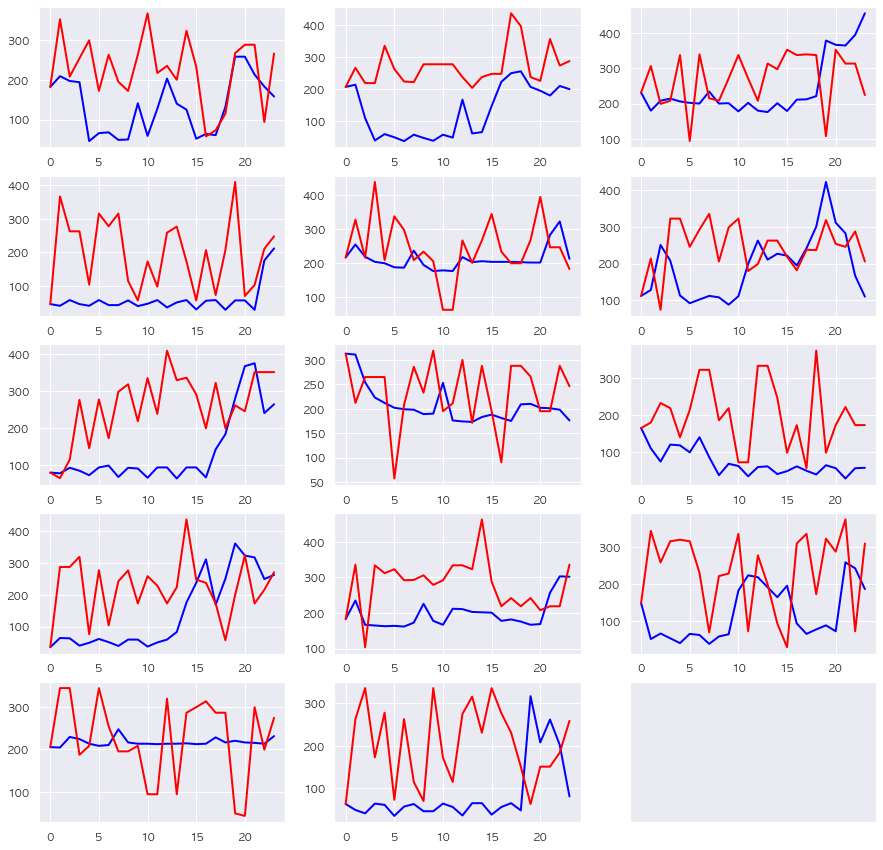

In [110]:
# visual
fig, axes = plt.subplots(5,3, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

test_real = list()
test_predict = list()

power_info = 1

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = model_2.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 3)][pi % 3], legend=False)
    sns.lineplot(data=test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 3)][pi % 3], legend=False)

real_pattern: [182. 209. 197. 194.  46.  66.  68.  49.  50. 141.  59. 127. 203. 140.
 125.  52.  64.  61. 132. 258. 258. 213. 183. 158.]


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict_pattern: [182.0, 209.0, 197.0, 194.0, 46.0, 172.0, 263.0, 195.0, 172.0, 263.0, 367.0, 217.0, 235.0, 200.0, 323.0, 233.0, 58.0, 73.0, 115.0, 267.0, 288.0, 288.0, 94.0, 266.0]
real_pattern: [207. 214. 109.  39.  59.  49.  37.  57.  47.  38.  57.  48. 167.  61.
  65. 147. 223. 250. 256. 207. 195. 180. 210. 200.]
predict_pattern: [207.0, 214.0, 109.0, 39.0, 59.0, 263.0, 224.0, 222.0, 278.0, 278.0, 278.0, 278.0, 238.0, 204.0, 238.0, 248.0, 248.0, 438.0, 398.0, 238.0, 226.0, 357.0, 274.0, 288.0]
real_pattern: [231. 180. 208. 214. 206. 202. 200. 234. 200. 201. 178. 202. 180. 176.
 201. 179. 211. 212. 221. 378. 366. 364. 394. 455.]
predict_pattern: [231.0, 180.0, 208.0, 214.0, 206.0, 94.0, 339.0, 215.0, 208.0, 271.0, 337.0, 271.0, 208.0, 313.0, 297.0, 352.0, 337.0, 339.0, 337.0, 108.0, 352.0, 313.0, 313.0, 224.0]
real_pattern: [ 46.  41.  58.  46.  41.  58.  43.  43.  57.  40.  47.  58.  36.  51.
  58.  30.  56.  58.  29.  57.  57.  29. 176. 212.]
predict_pattern: [46.0, 41.0, 58.0, 46

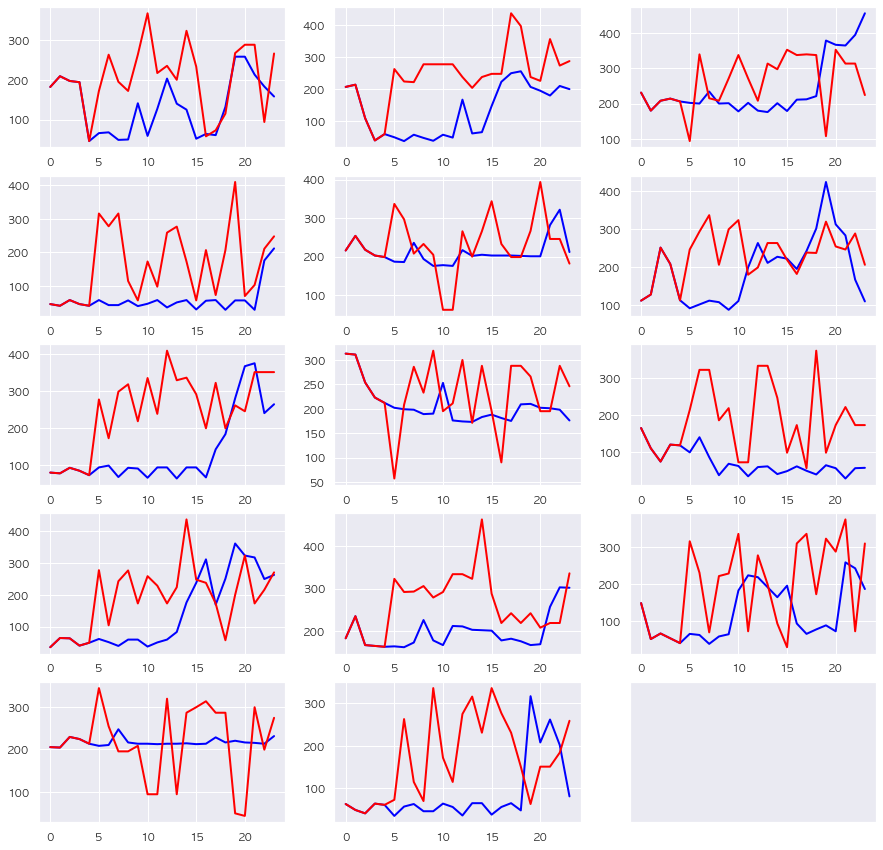

In [111]:
# visual
fig, axes = plt.subplots(5,3, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

test_real = list()
test_predict = list()

power_info = 5

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = model_2.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 3)][pi % 3], legend=False)
    sns.lineplot(data=test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 3)][pi % 3], legend=False)

real_pattern: [182. 209. 197. 194.  46.  66.  68.  49.  50. 141.  59. 127. 203. 140.
 125.  52.  64.  61. 132. 258. 258. 213. 183. 158.]


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict_pattern: [182.0, 209.0, 197.0, 194.0, 46.0, 66.0, 68.0, 49.0, 50.0, 141.0, 367.0, 217.0, 235.0, 200.0, 323.0, 233.0, 58.0, 73.0, 115.0, 267.0, 288.0, 288.0, 94.0, 266.0]
real_pattern: [207. 214. 109.  39.  59.  49.  37.  57.  47.  38.  57.  48. 167.  61.
  65. 147. 223. 250. 256. 207. 195. 180. 210. 200.]
predict_pattern: [207.0, 214.0, 109.0, 39.0, 59.0, 49.0, 37.0, 57.0, 47.0, 38.0, 278.0, 278.0, 238.0, 204.0, 238.0, 248.0, 248.0, 438.0, 398.0, 238.0, 226.0, 357.0, 274.0, 288.0]
real_pattern: [231. 180. 208. 214. 206. 202. 200. 234. 200. 201. 178. 202. 180. 176.
 201. 179. 211. 212. 221. 378. 366. 364. 394. 455.]
predict_pattern: [231.0, 180.0, 208.0, 214.0, 206.0, 202.0, 200.0, 234.0, 200.0, 201.0, 337.0, 271.0, 208.0, 313.0, 297.0, 352.0, 337.0, 339.0, 337.0, 108.0, 352.0, 313.0, 313.0, 224.0]
real_pattern: [ 46.  41.  58.  46.  41.  58.  43.  43.  57.  40.  47.  58.  36.  51.
  58.  30.  56.  58.  29.  57.  57.  29. 176. 212.]
predict_pattern: [46.0, 41.0, 58.0, 46.0, 41.0

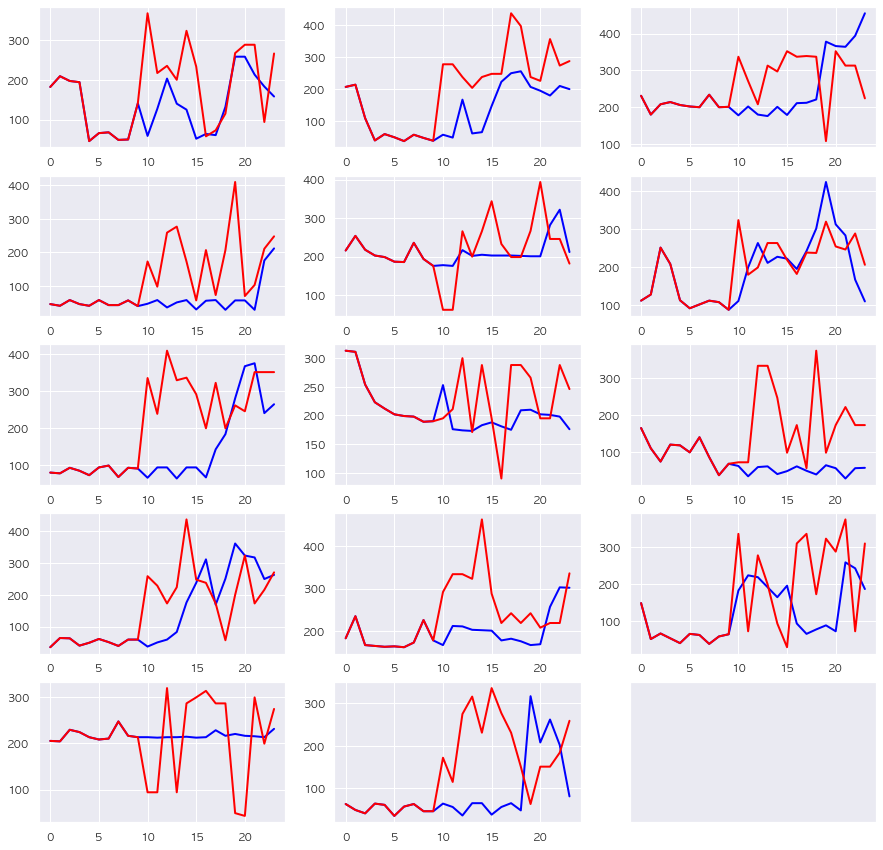

In [112]:
# visual
fig, axes = plt.subplots(5,3, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

test_real = list()
test_predict = list()

power_info = 10

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = model_2.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 3)][pi % 3], legend=False)
    sns.lineplot(data=test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 3)][pi % 3], legend=False)

real_pattern: [182. 209. 197. 194.  46.  66.  68.  49.  50. 141.  59. 127. 203. 140.
 125.  52.  64.  61. 132. 258. 258. 213. 183. 158.]


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict_pattern: [182.0, 209.0, 197.0, 194.0, 46.0, 66.0, 68.0, 49.0, 50.0, 141.0, 59.0, 127.0, 203.0, 140.0, 125.0, 233.0, 58.0, 73.0, 115.0, 267.0, 288.0, 288.0, 94.0, 266.0]
real_pattern: [207. 214. 109.  39.  59.  49.  37.  57.  47.  38.  57.  48. 167.  61.
  65. 147. 223. 250. 256. 207. 195. 180. 210. 200.]
predict_pattern: [207.0, 214.0, 109.0, 39.0, 59.0, 49.0, 37.0, 57.0, 47.0, 38.0, 57.0, 48.0, 167.0, 61.0, 65.0, 248.0, 248.0, 438.0, 398.0, 238.0, 226.0, 357.0, 274.0, 288.0]
real_pattern: [231. 180. 208. 214. 206. 202. 200. 234. 200. 201. 178. 202. 180. 176.
 201. 179. 211. 212. 221. 378. 366. 364. 394. 455.]
predict_pattern: [231.0, 180.0, 208.0, 214.0, 206.0, 202.0, 200.0, 234.0, 200.0, 201.0, 178.0, 202.0, 180.0, 176.0, 201.0, 352.0, 337.0, 339.0, 337.0, 108.0, 352.0, 313.0, 313.0, 224.0]
real_pattern: [ 46.  41.  58.  46.  41.  58.  43.  43.  57.  40.  47.  58.  36.  51.
  58.  30.  56.  58.  29.  57.  57.  29. 176. 212.]
predict_pattern: [46.0, 41.0, 58.0, 46.0, 41.0, 58.

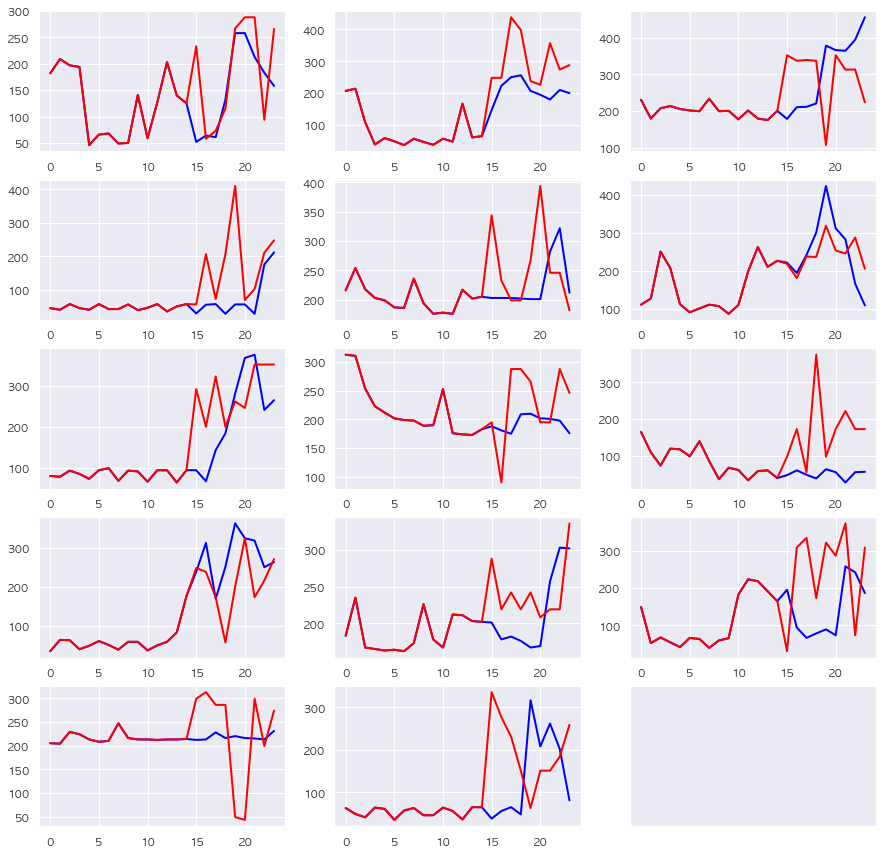

In [113]:
# visual
fig, axes = plt.subplots(5,3, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

test_real = list()
test_predict = list()

power_info = 15

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = model_2.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 3)][pi % 3], legend=False)
    sns.lineplot(data=test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 3)][pi % 3], legend=False)

In [115]:
model_2.save("model/아파트1-104-1206")

INFO:tensorflow:Assets written to: model/아파트1-104-1206/assets


INFO:tensorflow:Assets written to: model/아파트1-104-1206/assets


In [123]:
from tensorflow.keras.models import load_model
test_save_model = load_model("model/아파트1-104-1206")
test_save_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 28, 10)            18720     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dense_9 (Dense)              (None, 1872)              121680    
Total params: 159,600
Trainable params: 159,600
Non-trainable params: 0
_________________________________________________________________


real_pattern: [182. 209. 197. 194.  46.  66.  68.  49.  50. 141.  59. 127. 203. 140.
 125.  52.  64.  61. 132. 258. 258. 213. 183. 158.]


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict_pattern: [182.0, 209.0, 197.0, 194.0, 46.0, 66.0, 68.0, 49.0, 50.0, 141.0, 59.0, 127.0, 203.0, 140.0, 125.0, 233.0, 58.0, 73.0, 115.0, 267.0, 288.0, 288.0, 94.0, 266.0]
real_pattern: [207. 214. 109.  39.  59.  49.  37.  57.  47.  38.  57.  48. 167.  61.
  65. 147. 223. 250. 256. 207. 195. 180. 210. 200.]
predict_pattern: [207.0, 214.0, 109.0, 39.0, 59.0, 49.0, 37.0, 57.0, 47.0, 38.0, 57.0, 48.0, 167.0, 61.0, 65.0, 248.0, 248.0, 438.0, 398.0, 238.0, 226.0, 357.0, 274.0, 288.0]
real_pattern: [231. 180. 208. 214. 206. 202. 200. 234. 200. 201. 178. 202. 180. 176.
 201. 179. 211. 212. 221. 378. 366. 364. 394. 455.]
predict_pattern: [231.0, 180.0, 208.0, 214.0, 206.0, 202.0, 200.0, 234.0, 200.0, 201.0, 178.0, 202.0, 180.0, 176.0, 201.0, 352.0, 337.0, 339.0, 337.0, 108.0, 352.0, 313.0, 313.0, 224.0]
real_pattern: [ 46.  41.  58.  46.  41.  58.  43.  43.  57.  40.  47.  58.  36.  51.
  58.  30.  56.  58.  29.  57.  57.  29. 176. 212.]
predict_pattern: [46.0, 41.0, 58.0, 46.0, 41.0, 58.

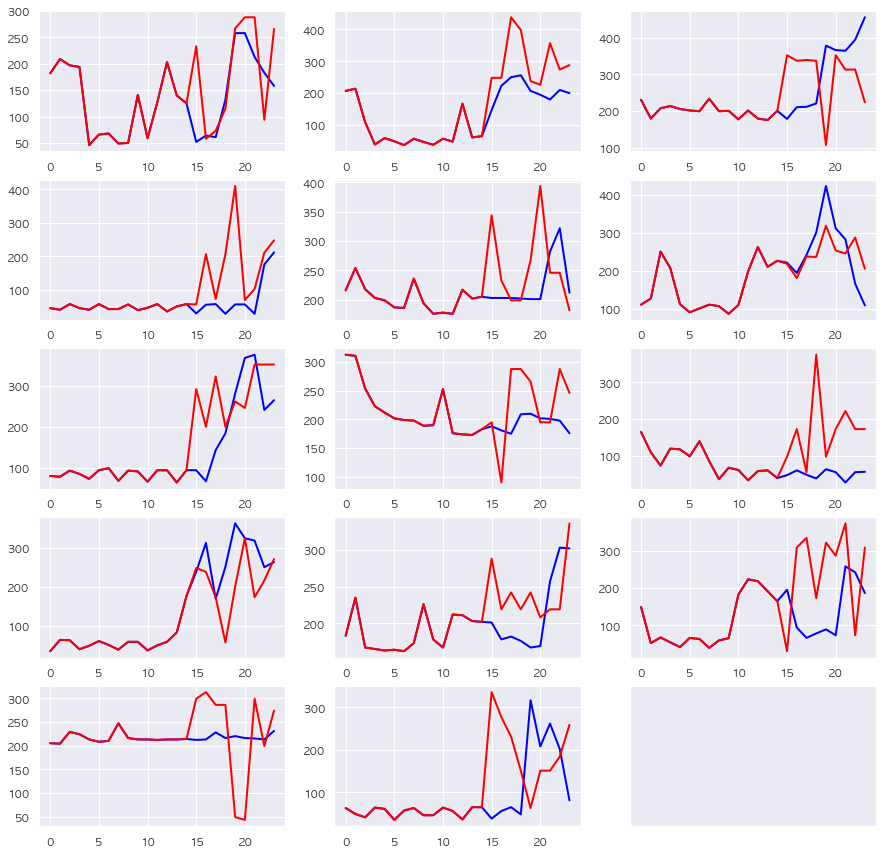

In [124]:
# visual
fig, axes = plt.subplots(5,3, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

test_real = list()
test_predict = list()

power_info = 15

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = test_save_model.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 3)][pi % 3], legend=False)
    sns.lineplot(data=test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 3)][pi % 3], legend=False)

In [97]:
client.close()